In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sales-forecasting/train.csv


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
import warnings
import itertools


%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("/kaggle/input/sales-forecasting/train.csv")
df.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62


Start by extracting the columns that I'll be working on!

In [4]:
df = pd.DataFrame(df[['Order Date' , 'Sales']])
df.head(5)

,Order Date,Sales
0,08/11/2017,261.9600
1,08/11/2017,731.9400
2,12/06/2017,14.6200
3,11/10/2016,957.5775
4,11/10/2016,22.3680


In [5]:
df.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Order Date  9800 non-null   object 
 1   Sales       9800 non-null   float64
dtypes: float64(1), object(1)
memory usage: 153.2+ KB


In [7]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')

In [8]:
df = df.sort_values('Order Date').set_index("Order Date")

In [9]:
df.head(3)

,Sales
Order Date,
2015-01-03,16.448
2015-01-04,3.540
2015-01-04,272.736


In [10]:
df['Sales'] = df.groupby('Order Date')['Sales'].mean()
df.head(5)

,Sales
Order Date,
2015-01-03,16.448
2015-01-04,96.020
2015-01-04,96.020
2015-01-04,96.020
2015-01-05,19.536


In [11]:
df.drop_duplicates(inplace=True)
df.head(5)

,Sales
Order Date,
2015-01-03,16.448000
2015-01-04,96.020000
2015-01-05,19.536000
2015-01-06,489.677778
2015-01-07,43.579000


In [12]:
df.shape

(1229, 1)

<Axes: xlabel='Order Date'>

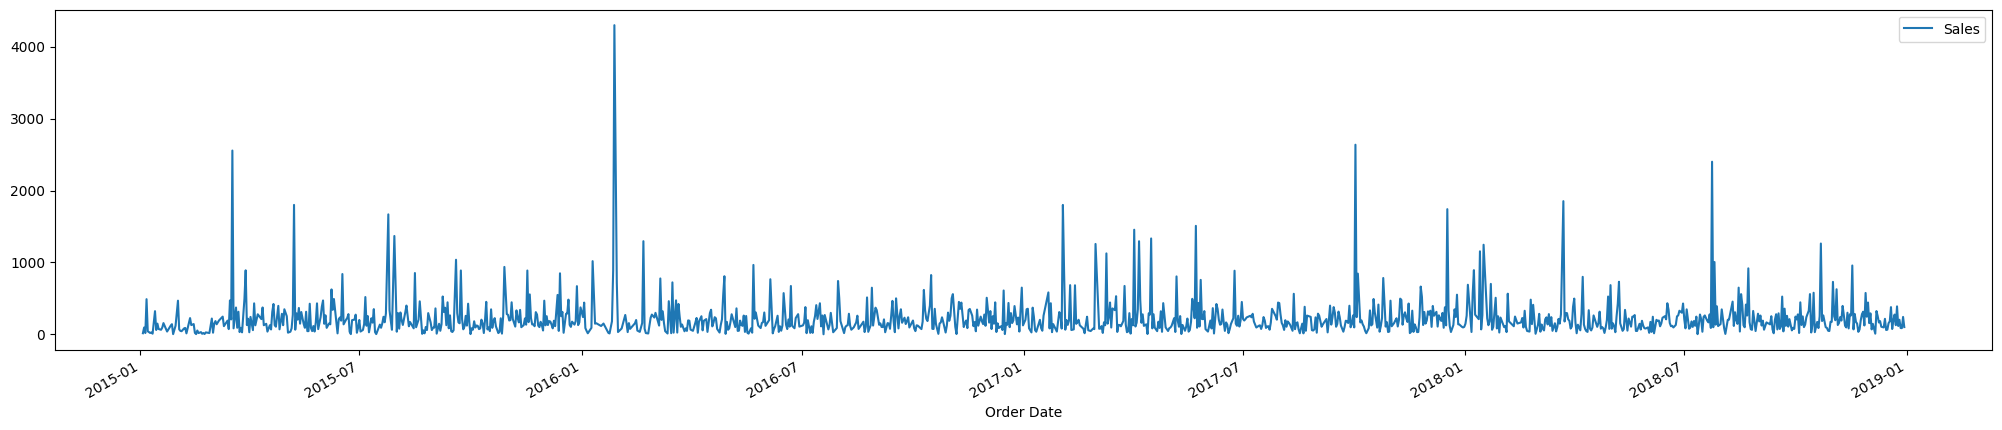

In [13]:
df.plot(figsize=(25,5))

The plot above represents the sales distribution over a span of 3 years. Typically, the sales range from 0 to 1000 units, but there are periodic peaks, often coinciding with festive seasons or special events related to the specific item being sold. This insight can guide us to explore stationarity and seasonality in the data for deeper understanding. Let's proceed to analyze stationarity and potential seasonal patterns, which could offer valuable insights.

In [14]:
df_original = df.copy()

## Check for Stationarity

In [15]:
from statsmodels.tsa.stattools import adfuller

In [16]:
def adf_test(series):
    result = adfuller(series)
    print('ADR Statistics: {}'.format(result[0]))
    print("P- value: {}". format(result[1]))
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. The data has no unit root and it is stationary")
    else:
        print("Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary")

In [17]:
adf_test(df['Sales'])

ADR Statistics: -20.338003091222504
P- value: 0.0
Strong evidence against the null hypothesis, reject the null hypothesis. The data has no unit root and it is stationary


In [18]:
## check for 12 months differencing (seasonal data)
df['Sales_12_diff'] = df['Sales'] - df['Sales'].shift(12)

In [19]:
adf_test(df['Sales_12_diff'].dropna())

ADR Statistics: -13.286099666325944
P- value: 7.523011025658791e-25
Strong evidence against the null hypothesis, reject the null hypothesis. The data has no unit root and it is stationary


In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

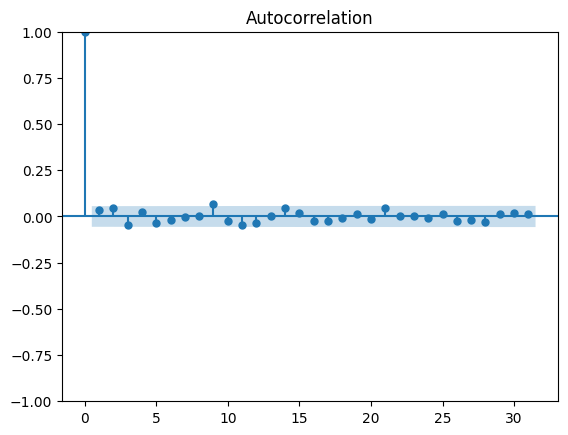

In [21]:
acf = plot_acf(df['Sales'].dropna())    #q=0

The autocorrelation function (ACF) plot is a tool for understanding the correlation between the sales data and its lagged values, revealing patterns and potential seasonality. Each bar in the plot represents the correlation at a specific lag. In the above plot, since all bars remain within the significance level boundaries, we can confidently conclude that there are no significant correlations between the months. This suggests an absence of potential yearly seasonality, making it less likely that the sales data is influenced by annual trends or events (q = 0).

However, to further explore potential seasonality, we've engineered seasonal data. Let's investigate this additional angle to gain more insights into any underlying patterns or trends.

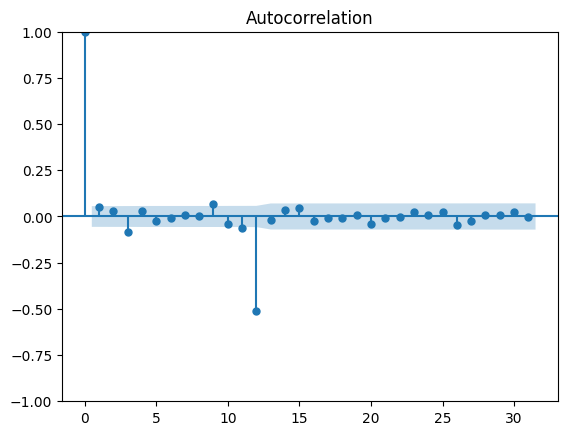

In [22]:
acf = plot_acf(df['Sales_12_diff'].dropna())    #q=1

Still no significant pattern can be observed from the data, however this polt shows that few bars are above the significance level, indicating some co-relation, so i'll make q=3 (for seasonal data)

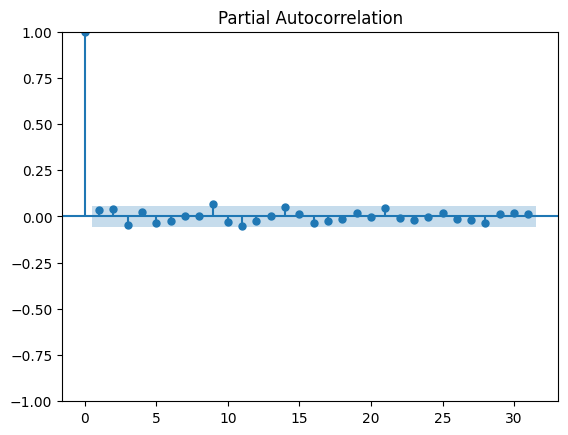

In [23]:
pacf = plot_pacf(df['Sales'].dropna())             # p = 0

The partial autocorrelation function (PACF) plot delves deeper into the autocorrelation structure of the sales data. Unlike the ACF plot, which shows direct correlations, the PACF plot displays the correlations between a lag and the series with the effects of all shorter lags removed. Each bar represents the partial correlation at a specific lag.

We can observe that few bars are pretty close to the significance level, indicating potential correlation. To uncover more about this apparent seasonality and understand its impact on the sales data, we will analyze the engineered seasonal data in detail.

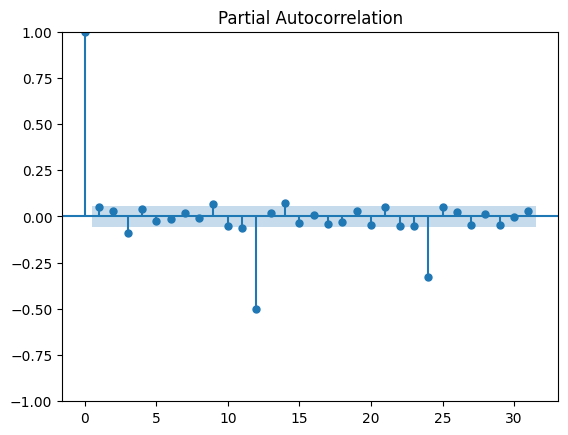

In [24]:
pacf = plot_pacf(df['Sales_12_diff'].dropna())   #p=1

As anticipated, the PACF plot reveals clear spikes at approximately week 12 and 24, surpassing the significance level in the negative direction. These pronounced spikes suggest a strong seasonal pattern present in the data at these intervals.

This seasonality aligns with our expectations, implying that certain weeks exhibit a recurring trend or behavior. Further analysis will delve into the specifics of this seasonality and its implications for our sales data, providing deeper insights into the underlying patterns and aiding in effective forecasting

In [24]:
df.tail

<bound method NDFrame.tail of                  Sales  Sales_12_diff
Order Date                           
2015-01-03   16.448000            NaN
2015-01-04   96.020000            NaN
2015-01-05   19.536000            NaN
2015-01-06  489.677778            NaN
2015-01-07   43.579000            NaN
...                ...            ...
2018-12-26  203.648500     -12.891167
2018-12-27   88.818000      27.440400
2018-12-28   87.228989      21.174989
2018-12-29  242.961167      86.979782
2018-12-30  101.970000     -80.325550

[1229 rows x 2 columns]>

In [25]:
from datetime import datetime, timedelta
train_dataset_end = datetime(2018, 5, 1)
test_dataset_end = datetime(2018, 12, 30)

In [26]:
train_data = df[:train_dataset_end]
test_data = df[train_dataset_end + timedelta(days=1):test_dataset_end]

In [27]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [28]:
test_data

,Sales,Sales_12_diff
Order Date,,
2018-05-02,79.822000,-25.539400
2018-05-03,154.038444,-2.782056
2018-05-04,114.624500,-201.272833
2018-05-05,30.853833,-49.094300
2018-05-06,249.283483,146.110372
...,...,...
2018-12-26,203.648500,-12.891167
2018-12-27,88.818000,27.440400
2018-12-28,87.228989,21.174989


## Create ARIMA model

In [29]:
from statsmodels.tsa.arima.model import ARIMA

In [42]:
model_ARIMA = ARIMA(train_data['Sales'], order=(1,1,1))

In [43]:
model_ARIMA_fit = model_ARIMA.fit()

In [44]:
model_ARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                 1006
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7111.506
Date:                Fri, 06 Oct 2023   AIC                          14229.013
Time:                        04:19:29   BIC                          14243.751
Sample:                             0   HQIC                         14234.613
                               - 1006                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0501      0.032      1.579      0.114      -0.012       0.112
ma.L1         -0.9996      0.023    -43.638      0.000      -1.044      -0.955
sigma2      8.147e+04   1667.444     48.858      0.000    7.82e+04    8.47e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):            126516.78
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                             5.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        56.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Model Type and Order:**
The chosen model is SARIMAX(1, 1, 1), indicating a seasonal autoregressive order of 1, a differencing order of 1, and a moving average order of 1. This suggests a seasonal and differenced time series analysis.

**Log Likelihood and Information Criteria (AIC, BIC, HQIC):**
The log likelihood is -7111.506. Lower AIC, BIC, and HQIC values (AIC: 14229.013, BIC: 14243.751, HQIC: 14234.613) suggest a better-fitting model.

**Covariance Type:**
The covariance type used in the model estimation is the Outer Product of Gradient (OPG).

**Model Coefficients (ARIMA Parameters):**

ar.L1 (AR term): 0.0501
ma.L1 (MA term): -0.9996
Variance (Sigma^2):
The variance (sigma^2) of the model's residuals is approximately 8.147e+04, indicating the variability or dispersion of the data around the mean.

**Ljung-Box (Q) Statistic:**
The Ljung-Box statistic tests for the absence of serial correlation in the residuals. A high p-value (0.89) suggests no significant autocorrelation.

**Jarque-Bera Test:**
The Jarque-Bera test assesses the normality of the residuals. A very small p-value (p < 0.05) indicates that the residuals are not normally distributed.

**Heteroskedasticity (H):**
The Heteroskedasticity (H) value of 0.61 indicates the presence of heteroskedasticity in the residuals, suggesting that the variance of the error terms is not constant.

**Skewness and Kurtosis:**
The skewness is 5.61, indicating a highly skewed distribution of residuals, and the kurtosis is extremely high (56.81), indicating heavy tails in the distribution.

In [45]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

print(pred_start_date)
print(pred_end_date)

2018-05-02 00:00:00
2018-12-30 00:00:00


In [46]:
datetime(2018, 5, 2)

datetime.datetime(2018, 5, 2, 0, 0)

In [47]:
pd.to_datetime("2018-05-02")

Timestamp('2018-05-02 00:00:00')

In [48]:
pred = model_ARIMA_fit.get_forecast(steps = 223)
forecast = pd.DataFrame(data = pred.predicted_mean.to_list(), columns = ['Arima_forecast'], index = test_data.index)
forecast

,Arima_forecast
Order Date,
2018-05-02,251.740226
2018-05-03,230.047811
2018-05-04,228.961035
2018-05-05,228.906589
2018-05-06,228.903861
...,...
2018-12-26,228.903717
2018-12-27,228.903717
2018-12-28,228.903717


In [49]:
test_data = pd.concat([test_data, forecast], axis = 1)

In [50]:
test_data.head()

,Sales,Sales_12_diff,Arima_forecast
Order Date,,,
2018-05-02,79.822000,-25.539400,251.740226
2018-05-03,154.038444,-2.782056,230.047811
2018-05-04,114.624500,-201.272833,228.961035
2018-05-05,30.853833,-49.094300,228.906589
2018-05-06,249.283483,146.110372,228.903861


<Axes: ylabel='Density'>

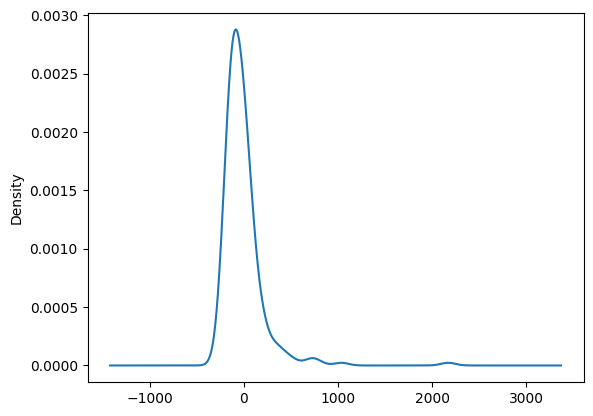

In [51]:
residuals = test_data['Sales'] - test_data['Arima_forecast']
residuals.plot(kind = 'kde')

The KDE plot of residuals visually represents the distribution of errors between the actual sales data and the ARIMA forecast. It helps us understand the pattern of errors. In this case, the plot shows that the residuals are approximately normally distributed, which is a good indication for the model's performance. Deviations from a normal distribution might suggest areas for model improvement or further analysis.

<Axes: xlabel='Order Date'>

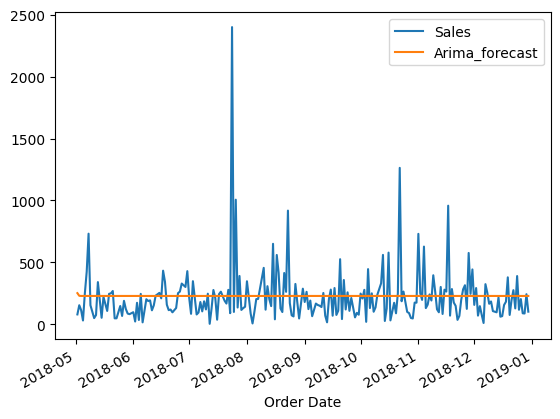

In [52]:
test_data[['Sales' , 'Arima_forecast']].plot()

If the ARIMA forecast is a straight line on the plot, it likely indicates that the ARIMA model is not capturing the variability and complexity present in the sales data. ARIMA models are linear and stationary, which means they assume a constant mean and variance over time. If the actual sales data has trends, seasonality, or other nonlinear patterns, the ARIMA model might not be able to accurately capture and forecast these patterns, resulting in a straight-line forecast.

To improve the forecast and capture nonlinear patterns, we may need to consider more advanced models, such as seasonal ARIMA (SARIMA), SARIMAX (including exogenous variables), or other time series forecasting methods like Prophet, LSTM (Long Short-Term Memory), or seasonal decomposition techniques.

## SARIMA

In [53]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [54]:
model_SARIMA = SARIMAX(train_data['Sales'], order = (1,1,1), seasonal_order = (0,1,0,12))

In [55]:
model_SARIMA_fit = model_SARIMA.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.42415D+00    |proj g|=  1.15076D-01

At iterate    5    f=  7.37381D+00    |proj g|=  1.26645D-02


 This problem is unconstrained.



At iterate   10    f=  7.36261D+00    |proj g|=  3.93529D-03

At iterate   15    f=  7.35099D+00    |proj g|=  1.79081D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     20      1     0     0   4.195D-06   7.351D+00
  F =   7.3509916290690507     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [57]:
model_SARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Sales   No. Observations:                 1006
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood               -7395.098
Date:                             Fri, 06 Oct 2023   AIC                          14796.195
Time:                                     04:29:13   BIC                          14810.897
Sample:                                          0   HQIC                         14801.785
                                            - 1006                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0660      0.034      1.959      0.050   -4.22e-05       0.132
ma.L1         -0.9999      0.534     -1.873      0.061      -2.046       0.046
sigma2      1.711e+05   9.13e+04      1.874      0.061   -7869.226     3.5e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             31239.60
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [58]:
test_data.tail()

,Sales,Sales_12_diff,Arima_forecast
Order Date,,,
2018-12-26,203.648500,-12.891167,228.903717
2018-12-27,88.818000,27.440400,228.903717
2018-12-28,87.228989,21.174989,228.903717
2018-12-29,242.961167,86.979782,228.903717
2018-12-30,101.970000,-80.325550,228.903717


In [59]:
pred = model_SARIMA_fit.get_forecast(steps = 223)
S_forecast = pd.DataFrame(data = pred.predicted_mean.to_list(), columns = ['Sarima_forecast'], index = test_data.index)
S_forecast

,Sarima_forecast
Order Date,
2018-05-02,134.224357
2018-05-03,159.820921
2018-05-04,317.191047
2018-05-05,81.129218
2018-05-06,104.346764
...,...
2018-12-26,338.307340
2018-12-27,102.245512
2018-12-28,125.463057


In [60]:
test_data = pd.concat([test_data, S_forecast], axis = 1)

In [61]:
test_data.head()

,Sales,Sales_12_diff,Arima_forecast,Sarima_forecast
Order Date,,,,
2018-05-02,79.822000,-25.539400,251.740226,134.224357
2018-05-03,154.038444,-2.782056,230.047811,159.820921
2018-05-04,114.624500,-201.272833,228.961035,317.191047
2018-05-05,30.853833,-49.094300,228.906589,81.129218
2018-05-06,249.283483,146.110372,228.903861,104.346764


<Axes: ylabel='Density'>

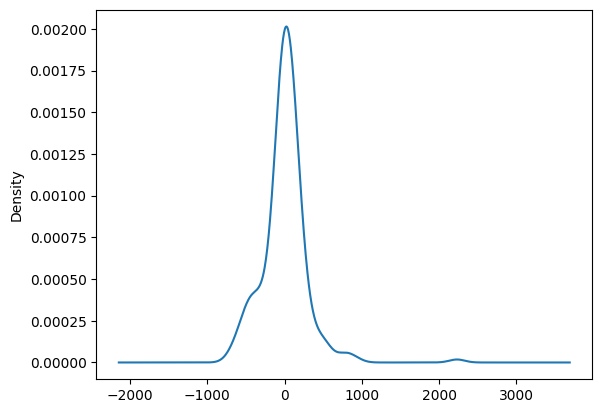

In [62]:
residuals = test_data['Sales'] - test_data['Sarima_forecast']
residuals.plot(kind = 'kde')

The kernel density estimate (KDE) plot of residuals displays a bell curve centered around -1000, peaking at values between 0 and 1000. The plot suggests that most of the residuals are concentrated in this range, creating the characteristic bell shape.

However, the plot also shows that the residuals have a wider spread, with some extending beyond -2000 to 3000 on the x-axis. The density of these extreme values is lower, indicated by the density values approaching 0. This suggests that while the majority of residuals are centered around zero and follow a bell curve, there are some outliers or instances with larger residual values.

<Axes: xlabel='Order Date'>

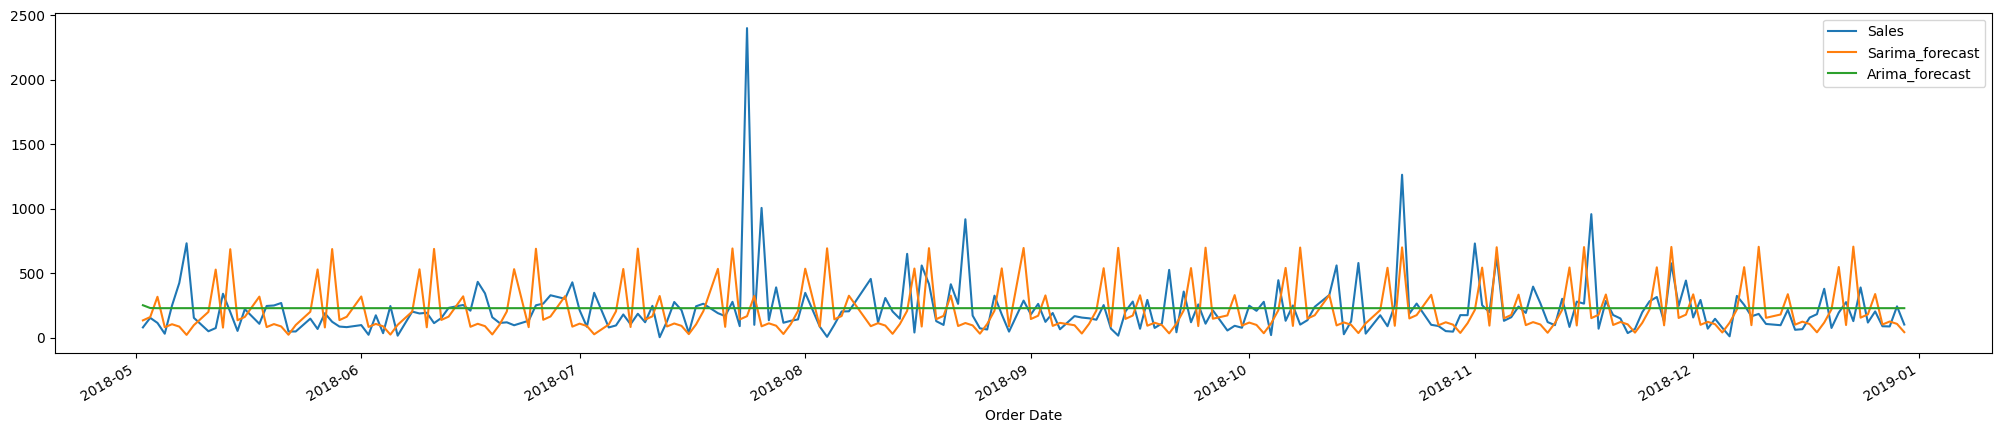

In [63]:
test_data[['Sales' , 'Sarima_forecast', "Arima_forecast"]].plot(figsize=(25,5))

The above plot shows the original Sales data, ARIMA forecasting and SARIMA forcasting we can clearly see that SARIMA was better at identifying the pattern towards the end, performing way better than the ARIMA model

## FbProphet

In [84]:
!pip install prophet

In [85]:
df1 = df_original.copy()

<Axes: xlabel='Order Date'>

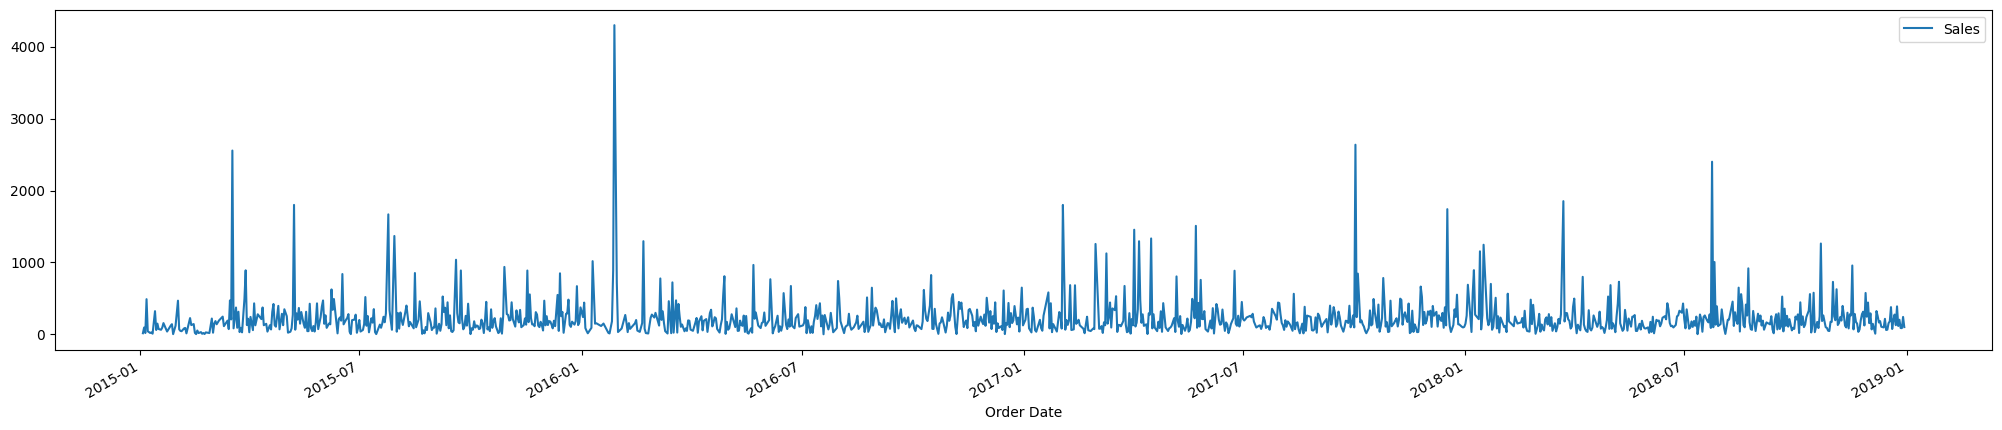

In [86]:
df1.plot(figsize=(25,5))

In [87]:
df1.reset_index(inplace=True)

In [88]:
df1.head(5)

,Order Date,Sales
0,2015-01-03,16.448000
1,2015-01-04,96.020000
2,2015-01-05,19.536000
3,2015-01-06,489.677778
4,2015-01-07,43.579000


Prophet requires it's datetime column to be names as "ds" and it's output value as "y". So, rename the columns

In [89]:
df1.columns = ["ds", "y"]
df1.head()

,ds,y
0,2015-01-03,16.448000
1,2015-01-04,96.020000
2,2015-01-05,19.536000
3,2015-01-06,489.677778
4,2015-01-07,43.579000


In [90]:
from prophet import Prophet

In [91]:
dir(Prophet)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_load_stan_backend',
 '_logistic_uncertainty',
 '_make_historical_mat_time',
 '_make_trend_shift_matrix',
 '_sample_uncertainty',
 'add_country_holidays',
 'add_group_component',
 'add_regressor',
 'add_seasonality',
 'construct_holiday_dataframe',
 'fit',
 'flat_growth_init',
 'flat_trend',
 'fourier_series',
 'initialize_scales',
 'linear_growth_init',
 'logistic_growth_init',
 'make_all_seasonality_features',
 'make_future_dataframe',
 'make_holiday_features',
 'make_seasonality_features',
 'parse_seasonality_args',
 'percentile',
 'piecewise_linear',
 'piecewise_logistic',
 'plot',
 'plot_components',
 'predict',
 'p

In [92]:
# Initialize the model
model = Prophet()

In [93]:
df1.head()

,ds,y
0,2015-01-03,16.448000
1,2015-01-04,96.020000
2,2015-01-05,19.536000
3,2015-01-06,489.677778
4,2015-01-07,43.579000


In [94]:
model.fit(df1)

04:37:26 - cmdstanpy - INFO - Chain [1] start processing
04:37:26 - cmdstanpy - INFO - Chain [1] done processing


In [95]:
future_dates = model.make_future_dataframe(periods=365)

In [96]:
future_dates.tail()

,ds
1589,2019-12-26
1590,2019-12-27
1591,2019-12-28
1592,2019-12-29
1593,2019-12-30


In [97]:
prediction = model.predict(future_dates)

In [98]:
prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-03,203.269966,-155.934786,510.956058,203.269966,203.269966,-24.281460,-24.281460,-24.281460,-8.100987,-8.100987,-8.100987,-16.180474,-16.180474,-16.180474,0.0,0.0,0.0,178.988506
1,2015-01-04,203.345416,-155.608218,560.628351,203.345416,203.345416,-2.842064,-2.842064,-2.842064,13.049137,13.049137,13.049137,-15.891201,-15.891201,-15.891201,0.0,0.0,0.0,200.503352
2,2015-01-05,203.420867,-159.470371,525.725498,203.420867,203.420867,-29.191251,-29.191251,-29.191251,-14.573635,-14.573635,-14.573635,-14.617616,-14.617616,-14.617616,0.0,0.0,0.0,174.229615
3,2015-01-06,203.496317,-184.666441,514.004955,203.496317,203.496317,-28.047625,-28.047625,-28.047625,-15.738068,-15.738068,-15.738068,-12.309557,-12.309557,-12.309557,0.0,0.0,0.0,175.448692
4,2015-01-07,203.571767,-118.193089,543.374952,203.571767,203.571767,-0.764661,-0.764661,-0.764661,8.177450,8.177450,8.177450,-8.942111,-8.942111,-8.942111,0.0,0.0,0.0,202.807106


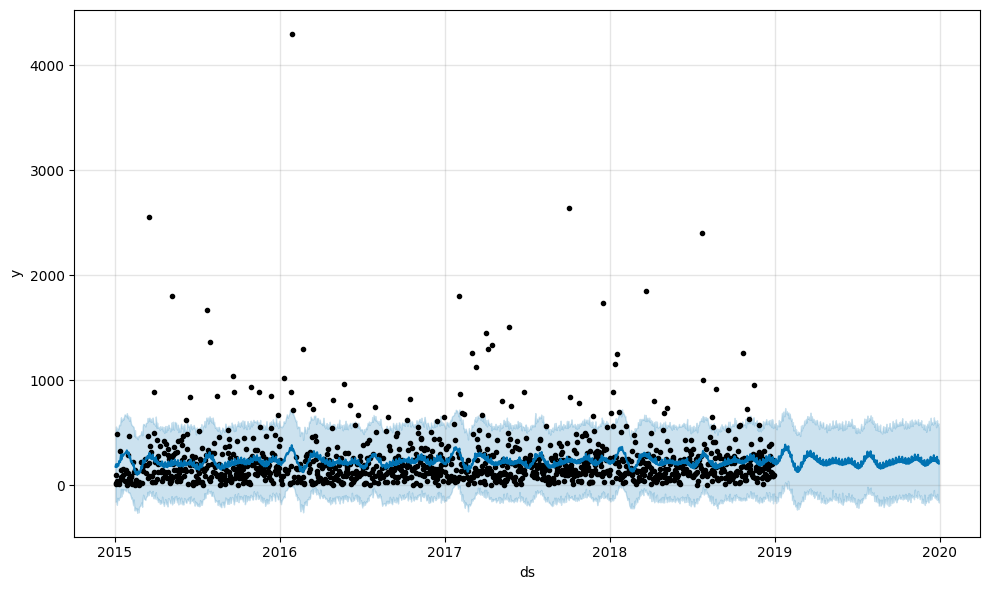

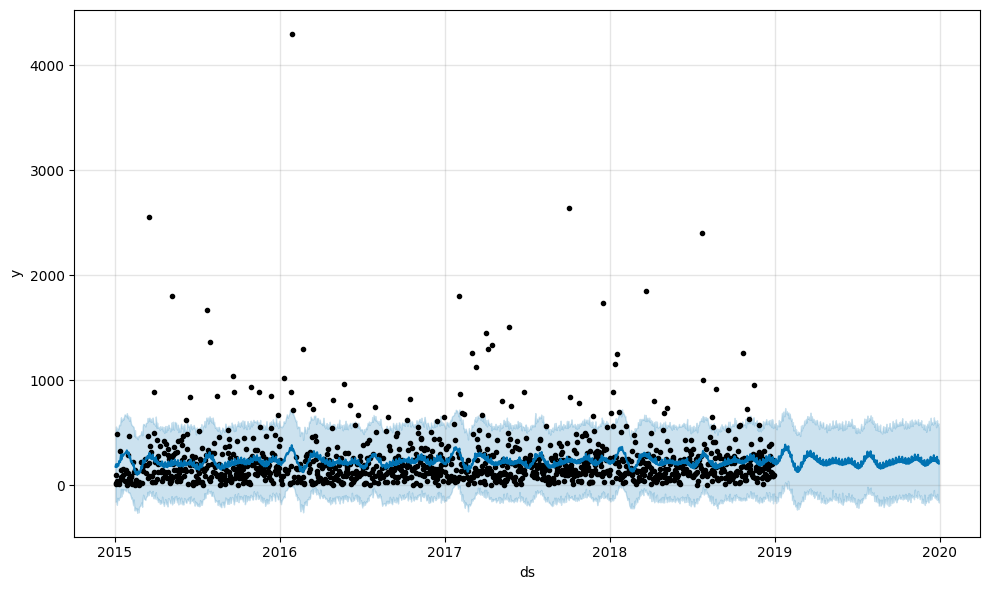

In [99]:
model.plot(prediction)

The scatter plot with the tiny black dots represents the actual sales values, predominantly concentrated within the range of 0-1000. Overlaying this, we have our model's predictions illustrated by the dark blue line generated using the FbProphet model. The light blue shaded area surrounding the prediction line signifies the confidence level, giving an idea of the plausible sales range.

Extending our predictions into the future, we've projected values for an entire year, spanning from 2019 to 2020. The blue line depicts these predicted values, and the light blue areas enveloping it illustrate the corresponding confidence intervals, offering insights into the expected variability and potential outcomes.

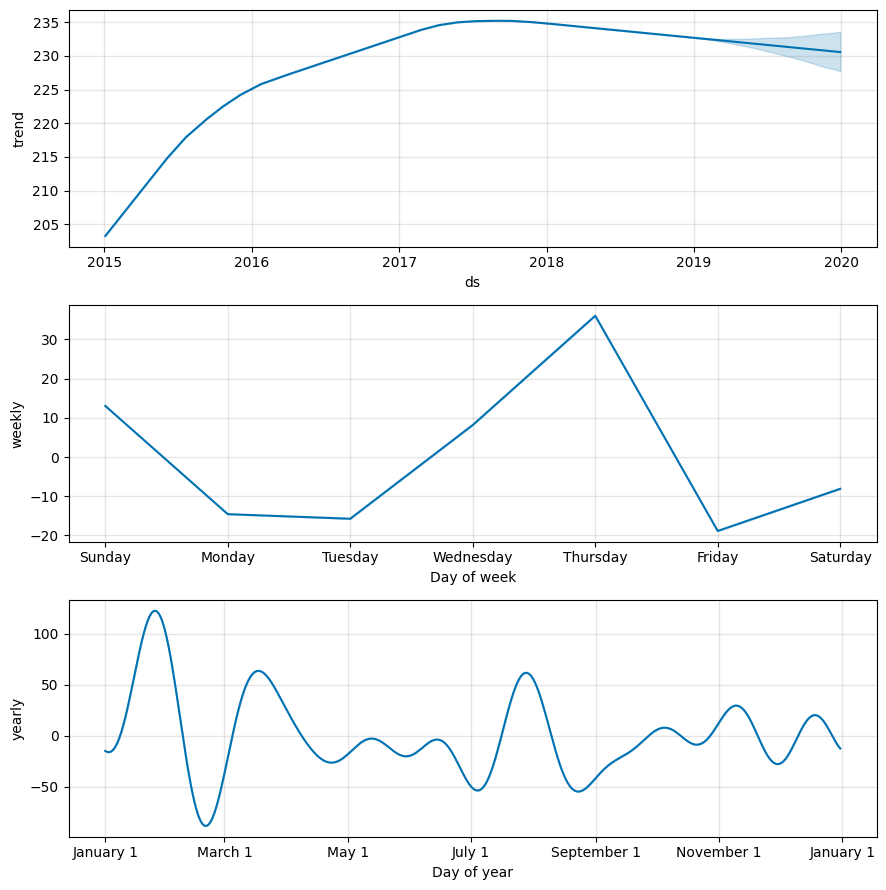

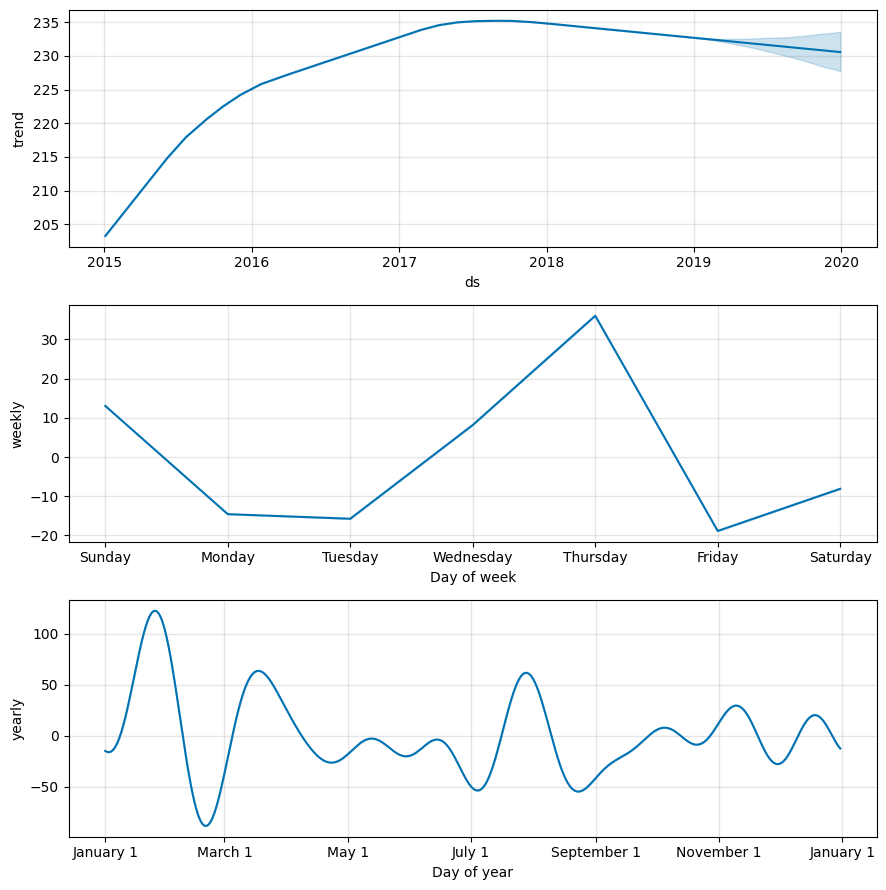

In [80]:
# Visualize each components(Trends, yearly)
model.plot_components(prediction)


The plot_components function showcases the distinct components of the time series data, allowing us to gain valuable insights into its structure.

Trends: This component demonstrates the overall trend observed in the sales data, aiding us in understanding its general trajectory over time. It reveals whether sales are steadily increasing, decreasing, or following a different pattern.

Yearly Seasonality: By examining the yearly component, we can identify any recurring patterns or seasonality that occurs on a yearly basis. This is particularly useful in understanding if sales tend to peak or dip during certain months or seasons, providing valuable insights for planning and decision-making.

In [100]:
from prophet.diagnostics import cross_validation
initial = int(0.8 * len(df))
df_cv = cross_validation(model, initial= str(initial)+' days', period="180 days", horizon = "365 days")
df_cv.head()

  0%|          | 0/1 [00:00<?, ?it/s]

04:45:55 - cmdstanpy - INFO - Chain [1] start processing
04:45:55 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-12-31,234.481528,-116.063498,593.590100,104.538286,2017-12-30
1,2018-01-01,178.615260,-180.991305,536.882624,148.182800,2017-12-30
2,2018-01-02,159.450152,-190.440437,512.770241,259.944250,2017-12-30
3,2018-01-03,205.611132,-169.399537,548.399720,690.090667,2017-12-30
4,2018-01-06,162.536801,-230.535351,500.046285,33.740000,2017-12-30


In [101]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,43 days,123953.303150,352.070026,258.992412,1.893835,0.799423,0.831739,0.78125
1,45 days,123430.165883,351.326295,255.307795,1.857478,0.753984,0.810176,0.78125
2,48 days,123460.594066,351.369598,255.718878,1.859208,0.753984,0.813724,0.78125
3,49 days,123381.858854,351.257539,255.299080,1.859056,0.753984,0.813492,0.78125
4,50 days,116218.228325,340.907947,242.473334,1.861280,0.778273,0.797112,0.81250


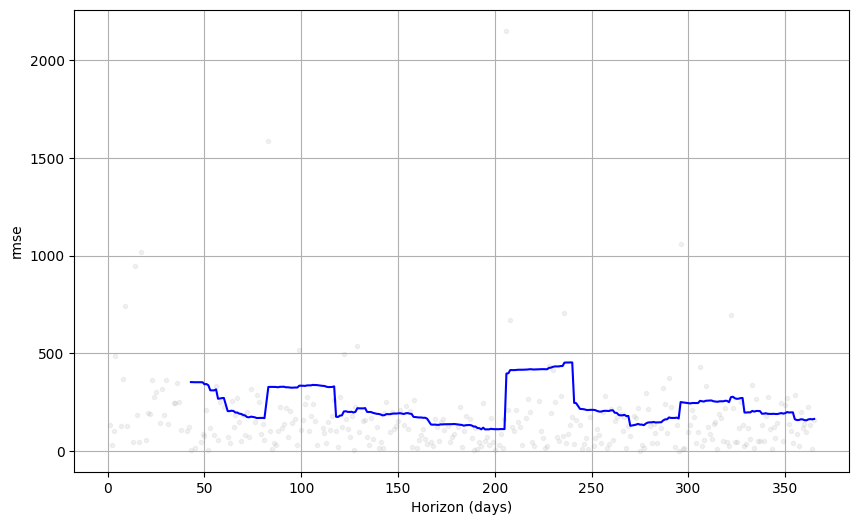

In [102]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric = "rmse")

The plot of Root Mean Squared Error (RMSE) across the cross-validation periods offers valuable insights into the model's performance. RMSE is a widely used metric to measure the forecasting accuracy. The plot displays the RMSE for each forecast horizon, indicating how well the model predictions align with the actual data. A lower RMSE signifies better model accuracy. Here, we observe that RMSE tends to increase as the forecast horizon extends at some periods, which is expected due to higher uncertainty in long-term predictions. Overall, the model appears to maintain reasonably low RMSE values, indicating good predictive performance.